In [2]:
import networkx as nx
from diffusion_models import Weighted_Cascade, Trivalency_Model, Independent_Cascade, Decreasing_Cascade, linear_threshold, general_threshold
from influence_max_algorithms import MIA
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
import time as time

from nbc import non_backtracking_centrality

import pickle


In [17]:
pb2020 = nx.read_gml('/Users/davidguzman/Documents/GitHub/Network-Science-final-Maximization-/Proud_Boys_Datsets/PB2020.gml')

In [18]:
#invert edge direction for PB2020
pb2020 = pb2020.reverse()

In [19]:
#print number of nodes and edges
print('Number of nodes: ', pb2020.number_of_nodes())
print('Number of edges: ', pb2020.number_of_edges())


Number of nodes:  13217
Number of edges:  14477


## is it indeed a power law?

In [20]:
from scipy.stats import poisson
from scipy.stats import expon
import powerlaw

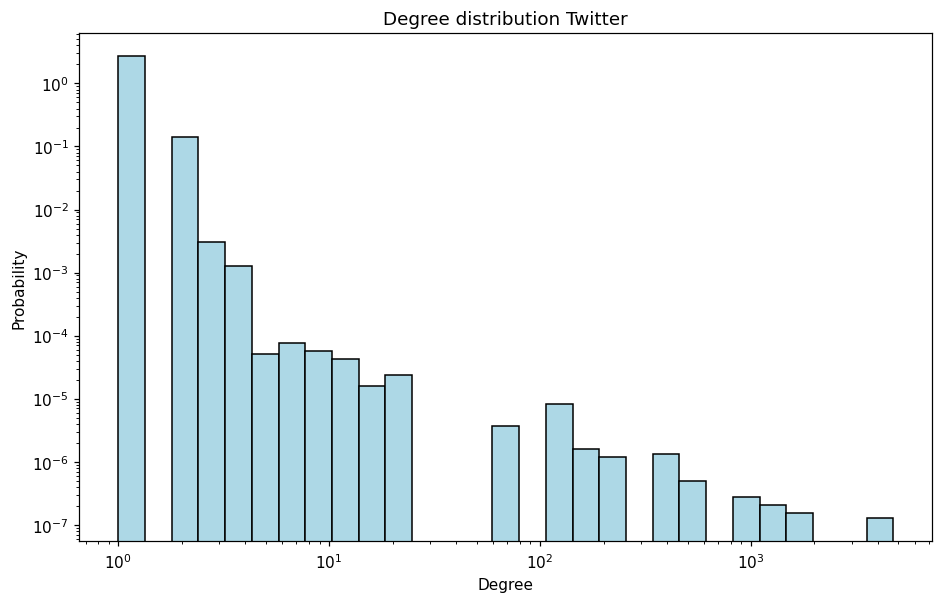

In [21]:
#degree distribution
deg = [d for n, d in pb2020.degree()]
plt.figure(figsize=(10,6), dpi=110)
my_bins = np.logspace(np.log10(min(deg)),np.log10(max(deg) +1), 30 ) 
plt.hist(deg, bins=my_bins, density = True, color = "lightblue", ec="black")
plt.title("Degree distribution Twitter")
plt.ylabel("Probability")
plt.xlabel("Degree") 
plt.xscale('log')
plt.yscale('log')
plt.show()

Calculating best minimal value for power law fit


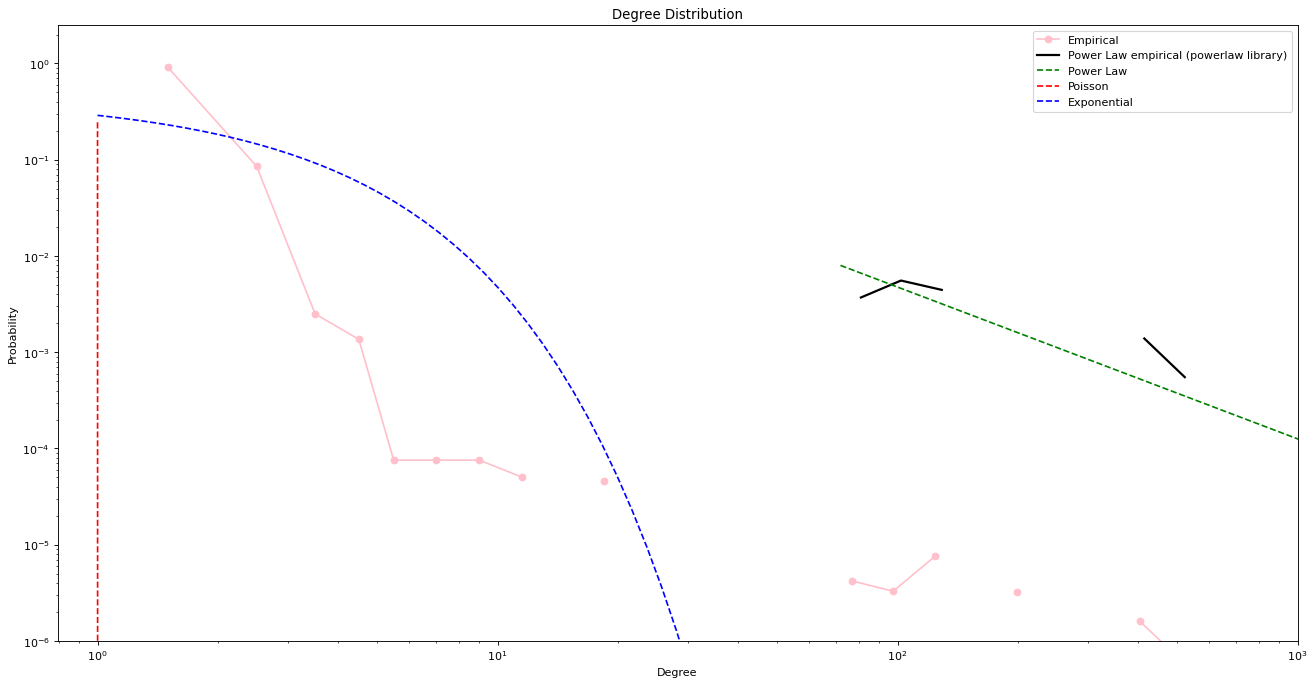

In [22]:
degree_sequence = sorted([d for n, d in pb2020.degree()], reverse=True)  # degree sequence

#plot powerlaw fit

fit = powerlaw.Fit(degree_sequence, discrete=True)

plt.figure(figsize=(20, 10), dpi=80)

powerlaw.plot_pdf(degree_sequence,color='pink',marker='o')
fit.plot_pdf(color='black', linewidth=2)
fit.power_law.plot_pdf(color='green', linestyle='--')

x = np.logspace(np.log10(min(degree_sequence)),np.log10(max(degree_sequence)), 100 )
plt.plot(x, poisson.pmf(x, np.mean(degree_sequence)), color='red', label='Poisson', linestyle='--')
plt.plot(x, expon.pdf(x, scale = np.mean(degree_sequence)), color='blue', label='Exponential',linestyle='--')

plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution')
plt.legend(['Empirical','Power Law empirical (powerlaw library)', 'Power Law', 'Poisson', 'Exponential'])
#limit x axis to make it more visible
plt.xlim(10**-0.1, 10**3)
plt.ylim(10**-6, 10**0.4)
plt.show()

## DBCM null model

In [23]:
from NEMtropy import UndirectedGraph, DirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist

In [24]:
# DBCM null model 
adj_WDN = nx.to_numpy_array(pb2020)
# Directed Binary CM
directed_adj_WDN = DirectedGraph(adj_WDN)
# dcm_exp is DBCM, which stands for Directed Binary Configuration Model
directed_adj_WDN.solve_tool(model= "dcm_exp",
                method="newton",
                initial_guess="random",
                adjacency="dcm_exp",
                method_adjacency="newton",
                max_steps = 10000)

/Users/davidguzman/miniforge3/envs/NS/lib/python3.10/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/Users/davidguzman/miniforge3/envs/NS/lib/python3.10/site-packages/NEMtropy/models_functions.py:3181: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
/Users/davidguzman/miniforge3/envs/NS/lib/python3.10/site-packages/NEMtropy/models_functions.py:3182: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
/Users/davidguzman/miniforge3/envs/NS/lib/python3.10/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 2.0143701848773787e-06


In [26]:
num_samples = 1
directed_adj_WDN.ensemble_sampler(num_samples, cpu_n=5, output_dir='sample_dcm_exp_WDN_/')


Process SpawnPoolWorker-3:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-5:
Process SpawnPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/davidguzman/miniforge3/envs/NS/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/davidguzman/miniforge3/envs/NS/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/davidguzman/miniforge3/envs/NS/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/davidguzman/miniforge3/envs/NS/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/davidguzman/miniforge3/envs/NS/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
KeyboardInterrupt
  File "/Users/david

KeyboardInterrupt: 

In [ ]:
edgelist_ens = np.loadtxt(f"sample_dcm_exp_WDN_//1.txt")

ens_adj = build_adjacency_from_edgelist(edgelist = edgelist_ens,
                                        is_directed = True,
                                        is_sparse = False,
                                        is_weighted = False)

pb2020_dbcm_null = nx.from_numpy_array(ens_adj, create_using=nx.DiGraph)

In [5]:
seed_size = 30

In [6]:
ICM_model_2020 = Independent_Cascade()
ICM_model_2020.fit(pb2020)
decreasing_cascade_model_2020 = Decreasing_Cascade()
decreasing_cascade_model_2020.fit(pb2020)
weighted_cascade_model_2020 = Weighted_Cascade()
weighted_cascade_model_2020.fit(pb2020)
trivalency_model_2020 = Trivalency_Model()
trivalency_model_2020.fit(pb2020)
linear_threshold_model_2020 = linear_threshold()
linear_threshold_model_2020.fit(pb2020)
general_threshold_model_2020 = general_threshold()
general_threshold_model_2020.fit(pb2020)

In [7]:
def assing_model_probs_to_weights(model):
    pb2020_model = pb2020.copy()
    for edge in pb2020_model.edges():
        prob = model.probability[model.label2id[edge[0]], model.label2id[edge[1]]]

        if pb2020_model.in_degree(edge[0]) == 0: # to avoid division by 0

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob + 0.00000001)) # to avoid diverging to - infinity
        else:

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob))
    return pb2020_model

In [8]:
def assing_model_probs_to_weights_threshold(model):
    pb2020_model = pb2020.copy()
    for edge in pb2020_model.edges():
        prob = model.influence[model.label2id[edge[0]], model.label2id[edge[1]]]

        if pb2020_model.in_degree(edge[0]) == 0: # to avoid division by 0

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob + 0.00000001)) # to avoid diverging to - infinity
        else:

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob))
    return pb2020_model

# Diffusion models + MIA

In [9]:
pb2020_independent_cascade = assing_model_probs_to_weights(ICM_model_2020)
pb2020_weighted_cascade = assing_model_probs_to_weights(weighted_cascade_model_2020)
pb2020_decreasing_cascade = assing_model_probs_to_weights(decreasing_cascade_model_2020)
pb2020_trivalency = assing_model_probs_to_weights(trivalency_model_2020)

In [10]:
pb2020_linear_threshold = assing_model_probs_to_weights_threshold(linear_threshold_model_2020)
pb2020_general_threshold = assing_model_probs_to_weights_threshold(general_threshold_model_2020)

In [18]:
mia = MIA(pb2020_weighted_cascade)
mia_icm = MIA(pb2020_independent_cascade)
mia_decreasing = MIA(pb2020_decreasing_cascade)
mia_trivalency = MIA(pb2020_trivalency)
mia_linear_threshold = MIA(pb2020_linear_threshold)
mia_general_threshold = MIA(pb2020_general_threshold)

### calcualtion of MIA

In [ ]:
seed_wcm = mia.MIA_fast(pb2020_weighted_cascade, 100, 0.5)

#remove duplicates
seed_wcm = list(dict.fromkeys(seed_wcm))

with open('seed_wcm.pickle', 'wb') as handle:
    pickle.dump(seed_wcm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
seed_icm = mia_icm.MIA_fast(pb2020_independent_cascade, 100, 0.5)
#remove duplicates
seed_icm = list(dict.fromkeys(seed_icm))
#pickle it
with open('seed_icm.pickle', 'wb') as handle:
    pickle.dump(seed_icm, handle, protocol=pickle.HIGHEST_PROTOCOL)


Starting MIA intialization


100%|██████████| 13217/13217 [00:46<00:00, 282.38it/s]


Initialization Completed


100%|██████████| 100/100 [20:41<00:00, 12.41s/it]


In [13]:
seed_dc = mia_decreasing.MIA_fast(pb2020_decreasing_cascade, 100, 0.5)
#remove duplicates
seed_dc = list(dict.fromkeys(seed_dc))
#pickle it
with open('seed_dc.pickle', 'wb') as handle:
    pickle.dump(seed_dc, handle, protocol=pickle.HIGHEST_PROTOCOL)

Starting MIA intialization


100%|██████████| 13217/13217 [00:45<00:00, 292.91it/s]


Initialization Completed


100%|██████████| 100/100 [19:18<00:00, 11.58s/it]


In [14]:
seed_trivalency = mia_trivalency.MIA_fast(pb2020_trivalency, 100, 0.5)
#remove duplicates
seed_trivalency = list(dict.fromkeys(seed_trivalency))
#pickle it
with open('seed_trivalency.pickle', 'wb') as handle:
    pickle.dump(seed_trivalency, handle, protocol=pickle.HIGHEST_PROTOCOL)

Starting MIA intialization


100%|██████████| 13217/13217 [00:44<00:00, 295.98it/s]


Initialization Completed


100%|██████████| 100/100 [18:20<00:00, 11.00s/it]


In [15]:
seed_lt = mia_linear_threshold.MIA_fast(pb2020_linear_threshold, 100, 0.5)
#remove duplicates
seed_lt = list(dict.fromkeys(seed_lt))
#pickle it
with open('seed_lt.pickle', 'wb') as handle:
    pickle.dump(seed_lt, handle, protocol=pickle.HIGHEST_PROTOCOL)

Starting MIA intialization


100%|██████████| 13217/13217 [00:42<00:00, 312.00it/s]


Initialization Completed


100%|██████████| 100/100 [18:21<00:00, 11.02s/it]


In [16]:
seed_gt = mia_general_threshold.MIA_fast(pb2020_general_threshold, 100, 0.5)
#remove duplicates
seed_gt = list(dict.fromkeys(seed_gt))
#pickle it
with open('seed_gt.pickle', 'wb') as handle:
    pickle.dump(seed_gt, handle, protocol=pickle.HIGHEST_PROTOCOL)

Starting MIA intialization


100%|██████████| 13217/13217 [00:44<00:00, 294.25it/s]


Initialization Completed


100%|██████████| 100/100 [19:11<00:00, 11.51s/it]


### loading pre-saved results 

In [11]:
#load the seeds
with open('seed_wcm.pickle', 'rb') as handle:
    seed_wcm = pickle.load(handle)
    
with open('seed_icm.pickle', 'rb') as handle:
    seed_icm = pickle.load(handle)

with open('seed_dc.pickle', 'rb') as handle:
    seed_dc = pickle.load(handle)

with open('seed_trivalency.pickle', 'rb') as handle:
    seed_trivalency = pickle.load(handle)

with open('seed_lt.pickle', 'rb') as handle:
    seed_lt = pickle.load(handle)

with open('seed_gt.pickle', 'rb') as handle:
    seed_gt = pickle.load(handle)

In [32]:
"""activate_nums = weighted_cascade_model_2020.monte_carlo_diffusion_all(seed_wcm[:seed_size], num_simulations=10)
print(activate_nums)
print('total nodes reached: ' + str(sum(activate_nums)))"""

[  30.  1679.1]
total nodes reached: 1709.1


In [12]:
#calcualate the number of nodes reached by the seed sets generated by MIA using seed sets of size 5, 10, 20
activate_nums_dict_wcm = {}
for i in range(1, 100, 5):
    seed_wcm_temp = seed_wcm[:i]
    activate_nums = weighted_cascade_model_2020.monte_carlo_diffusion_all(seed_wcm[:i], num_simulations=10)
    activate_nums_dict_wcm[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

#do the same for the other models
activate_nums_dict_icm = {}
for i in range(1, 100, 5):
    seed_icm_temp = seed_icm[:i]
    activate_nums = ICM_model_2020.monte_carlo_diffusion_all(seed_icm[:i], num_simulations=10)
    activate_nums_dict_icm[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_dc = {}
for i in range(1, 100, 5):
    seed_dc_temp = seed_dc[:i]
    activate_nums = decreasing_cascade_model_2020.monte_carlo_diffusion_all(seed_dc[:i], num_simulations=10)
    activate_nums_dict_dc[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_tr = {}
for i in range(1, 100, 5):
    seed_tr_temp = seed_trivalency[:i]
    activate_nums = trivalency_model_2020.monte_carlo_diffusion_all(seed_trivalency[:i], num_simulations=10)
    activate_nums_dict_tr[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_lt = {}
for i in range(1, 100, 5):
    seed_lt_temp = seed_lt[:i]
    activate_nums = linear_threshold_model_2020.diffusion_all(seed_lt[:i], 0.001)
    activate_nums_dict_lt[i] = sum(activate_nums[1])
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_gt = {}
for i in range(1, 100, 5):
    seed_gt_temp = seed_gt[:i]
    activate_nums = general_threshold_model_2020.diffusion_all(seed_gt[:i])
    activate_nums_dict_gt[i] = sum(activate_nums[1])
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))


# calcualting baseline (K-core and Non-Backtracking centrality) influence for each diffusion model 

#### K - core calculation

In [14]:
k_core_centralities = nx.core_number(pb2020)
# set it as an attribute
nx.set_node_attributes(pb2020, k_core_centralities, 'k_core_centralities')

# Since there are only 4 levels or k-shells in this case, in an effort to improve diffusion we sort first by shell and then by follower count (or some other attribute)

#for nodes without attribute 'followers', set it to 0
for node in pb2020.nodes():
    if 'followers' not in pb2020.nodes[node]:
        pb2020.nodes[node]['followers'] = 0

# sort by k_core_centralities first and by followers second
sorted_nodes = sorted(pb2020.nodes(data=True), key=lambda x: (x[1]['k_core_centralities'], x[1]['followers']), reverse=True)

#only the first element of the tuple
seed_k_core_by_follower = [x[0] for x in sorted_nodes]

# alternative sorted by out-degree

sorted_nodes = sorted(pb2020.nodes(data=True), key=lambda x: (x[1]['k_core_centralities'], pb2020.out_degree(x[0])), reverse=True)

seed_k_core_by_out_degree = [x[0] for x in sorted_nodes]


In [15]:
#calcualate the number of nodes reached by the seed sets generated by MIA using seed sets of size 5, 10, 20
activate_nums_dict_kcore_wcm = {}
for i in range(1, 100, 5):
    seed_kcore_wcm_temp = seed_k_core_by_out_degree[:i]
    activate_nums = weighted_cascade_model_2020.monte_carlo_diffusion_all(seed_k_core_by_out_degree[:i], num_simulations=10)
    activate_nums_dict_kcore_wcm[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

#do the same for the other models
activate_nums_dict_kcore_icm = {}
for i in range(1, 100, 5):
    seed_kcore_icm_temp = seed_k_core_by_out_degree[:i]
    activate_nums = ICM_model_2020.monte_carlo_diffusion_all(seed_k_core_by_out_degree[:i], num_simulations=10)
    activate_nums_dict_kcore_icm[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_kcore_dc = {}
for i in range(1, 100, 5):
    seed_kcore_dc_temp = seed_k_core_by_out_degree[:i]
    activate_nums = decreasing_cascade_model_2020.monte_carlo_diffusion_all(seed_k_core_by_out_degree[:i], num_simulations=10)
    activate_nums_dict_kcore_dc[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_kcore_tr = {}
for i in range(1, 100, 5):
    seed_kcore_tr_temp = seed_k_core_by_out_degree[:i]
    activate_nums = trivalency_model_2020.monte_carlo_diffusion_all(seed_k_core_by_out_degree[:i], num_simulations=10)
    activate_nums_dict_kcore_tr[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_kcore_lt = {}
for i in range(1, 100, 5):
    seed_kcore_lt_temp = seed_k_core_by_out_degree[:i]
    activate_nums = linear_threshold_model_2020.diffusion_all(seed_k_core_by_out_degree[:i], 0.001)
    activate_nums_dict_kcore_lt[i] = sum(activate_nums[1])
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_kcore_gt = {}
for i in range(1, 100, 5):
    seed_kcore_gt_temp = seed_k_core_by_out_degree[:i]
    activate_nums = general_threshold_model_2020.diffusion_all(seed_k_core_by_out_degree[:i])
    activate_nums_dict_kcore_gt[i] = sum(activate_nums[1])
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))


#### Non-backtracking centrality calculation

In [21]:
pb2020_int = nx.convert_node_labels_to_integers(pb2020)
#get the node labels in a list
node_labels = list(pb2020.nodes())
# calcualate the non-backtrack centrality
non_backtrack_centralities = non_backtracking_centrality(pb2020_int)
# use node labels to create a dictionary
non_backtrack_centralities_dict = dict(zip(node_labels, non_backtrack_centralities))
# add non-backtrack centrality as an attribute, the first element of the list goes with the first node, etc.
nx.set_node_attributes(pb2020, non_backtrack_centralities_dict, 'non_backtrack_centralities')
# sorted nodes by non-backtrack centrality, extracting its value from the attribute
name_nbc_pairs = [(node, pb2020.nodes[node]['non_backtrack_centralities']) for node in pb2020.nodes]
name_nbc_pairs.sort(key=lambda x: x[1], reverse=True)
#get only the labels in a list
name_nbc_pairs_labels = [x[0] for x in name_nbc_pairs]
seed_nbc = name_nbc_pairs_labels



In [23]:
#calcualate the number of nodes reached by the seed sets generated by MIA using seed sets of size 5, 10, 20
activate_nums_dict_nbc_wcm = {}
for i in range(1, 100, 5):
    seed_nbc_wcm_temp = seed_nbc[:i]
    activate_nums = weighted_cascade_model_2020.monte_carlo_diffusion_all(seed_nbc[:i], num_simulations=10)
    activate_nums_dict_nbc_wcm[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

#do the same for the other models
activate_nums_dict_nbc_icm = {}
for i in range(1, 100, 5):
    seed_nbc_icm_temp = seed_nbc[:i]
    activate_nums = ICM_model_2020.monte_carlo_diffusion_all(seed_nbc[:i], num_simulations=10)
    activate_nums_dict_nbc_icm[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_nbc_dc = {}
for i in range(1, 100, 5):
    seed_nbc_dc_temp = seed_nbc[:i]
    activate_nums = decreasing_cascade_model_2020.monte_carlo_diffusion_all(seed_nbc[:i], num_simulations=10)
    activate_nums_dict_nbc_dc[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_nbc_tr = {}
for i in range(1, 100, 5):
    seed_nbc_tr_temp = seed_nbc[:i]
    activate_nums = trivalency_model_2020.monte_carlo_diffusion_all(seed_nbc[:i], num_simulations=10)
    activate_nums_dict_nbc_tr[i] = sum(activate_nums)
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_nbc_lt = {}
for i in range(1, 100, 5):
    seed_nbc_lt_temp = seed_nbc[:i]
    activate_nums = linear_threshold_model_2020.diffusion_all(seed_nbc[:i], 0.001)
    activate_nums_dict_nbc_lt[i] = sum(activate_nums[1])
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))

activate_nums_dict_nbc_gt = {}
for i in range(1, 100, 5):
    seed_nbc_gt_temp = seed_nbc[:i]
    activate_nums = general_threshold_model_2020.diffusion_all(seed_nbc[:i])
    activate_nums_dict_nbc_gt[i] = sum(activate_nums[1])
    #print('total nodes reached with seed set of size ' + str(i) + ': ' + str(sum(activate_nums)))


# Plotting influence as a function of seed size

remember to point out that, while we plot the influence of the baselines for the different difussion models, its only the diffusion model that changes (for the baselines the seed does not change based on the model)

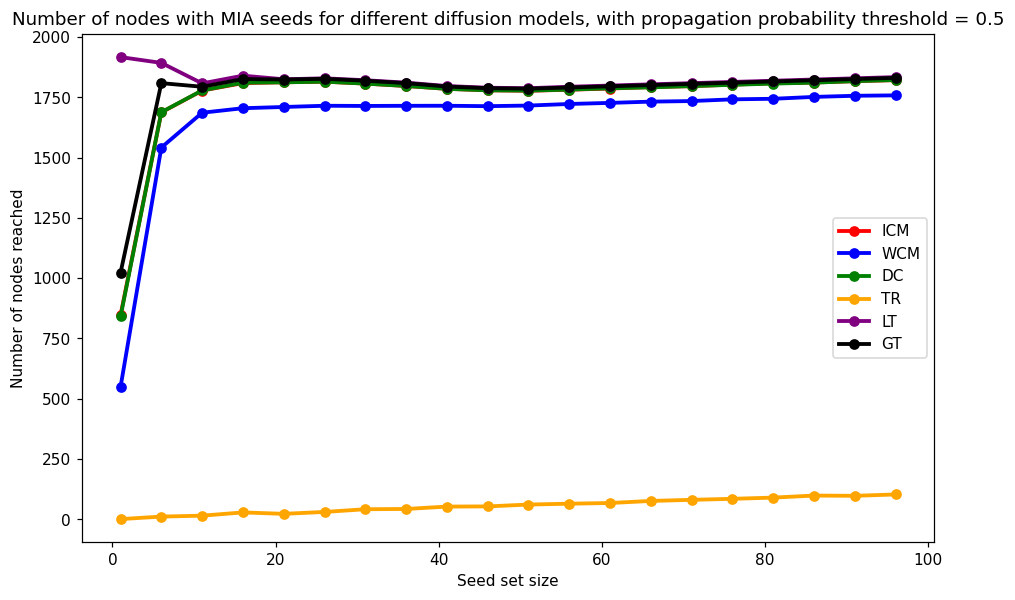

In [16]:
#plot the number of nodes reached by the seed sets generated by MIA using seed sets of size 5, 10, 20
plt.figure(figsize=(10,6), dpi=110)
plt.plot(activate_nums_dict_icm.keys(), activate_nums_dict_icm.values(), color = "red", linewidth=2.5, linestyle="-", label="ICM", marker="o")
plt.plot(activate_nums_dict_wcm.keys(), activate_nums_dict_wcm.values(), color = "blue", linewidth=2.5, linestyle="-", label="WCM", marker="o")
plt.plot(activate_nums_dict_dc.keys(), activate_nums_dict_dc.values(), color = "green", linewidth=2.5, linestyle="-", label="DC", marker="o")
plt.plot(activate_nums_dict_tr.keys(), activate_nums_dict_tr.values(), color = "orange", linewidth=2.5, linestyle="-", label="TR", marker="o")
plt.plot(activate_nums_dict_lt.keys(), activate_nums_dict_lt.values(), color = "purple", linewidth=2.5, linestyle="-", label="LT", marker="o")
plt.plot(activate_nums_dict_gt.keys(), activate_nums_dict_gt.values(), color = "black", linewidth=2.5, linestyle="-", label="GT", marker="o")
plt.title("Number of nodes with MIA seeds for different diffusion models, with propagation probability threshold = 0.5")
plt.ylabel("Number of nodes reached")
plt.xlabel("Seed set size")
plt.legend()
plt.show()

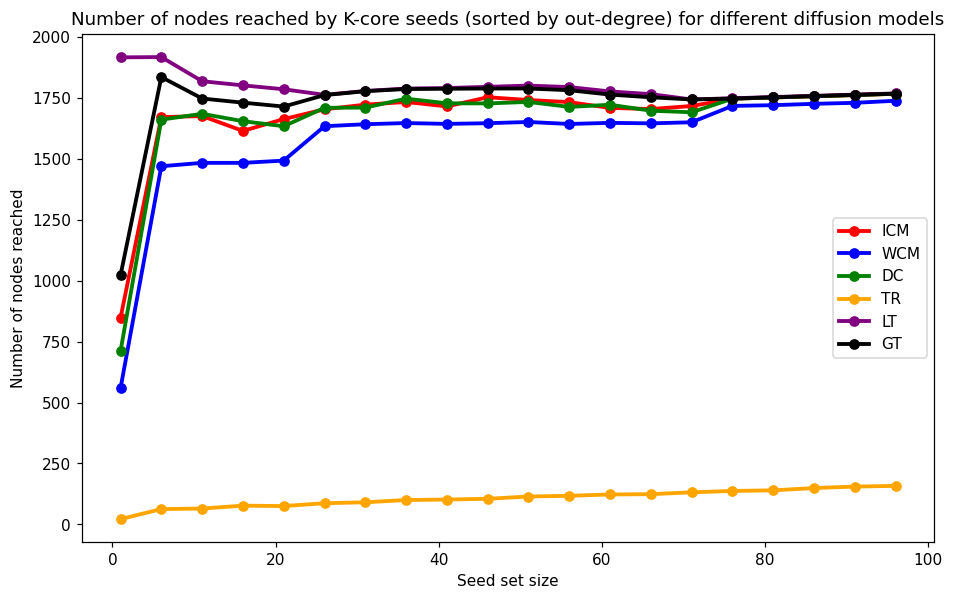

In [24]:
plt.figure(figsize=(10,6), dpi=110)
plt.plot(activate_nums_dict_kcore_icm.keys(), activate_nums_dict_kcore_icm.values(), color = "red", linewidth=2.5, linestyle="-", label="ICM", marker="o")
plt.plot(activate_nums_dict_kcore_wcm.keys(), activate_nums_dict_kcore_wcm.values(), color = "blue", linewidth=2.5, linestyle="-", label="WCM", marker="o")
plt.plot(activate_nums_dict_kcore_dc.keys(), activate_nums_dict_kcore_dc.values(), color = "green", linewidth=2.5, linestyle="-", label="DC", marker="o")
plt.plot(activate_nums_dict_kcore_tr.keys(), activate_nums_dict_kcore_tr.values(), color = "orange", linewidth=2.5, linestyle="-", label="TR", marker="o")
plt.plot(activate_nums_dict_kcore_lt.keys(), activate_nums_dict_kcore_lt.values(), color = "purple", linewidth=2.5, linestyle="-", label="LT", marker="o")
plt.plot(activate_nums_dict_kcore_gt.keys(), activate_nums_dict_kcore_gt.values(), color = "black", linewidth=2.5, linestyle="-", label="GT", marker="o")
plt.title("Number of nodes reached by K-core seeds (sorted by out-degree) for different diffusion models")
plt.ylabel("Number of nodes reached")
plt.xlabel("Seed set size")
plt.legend()
plt.show()

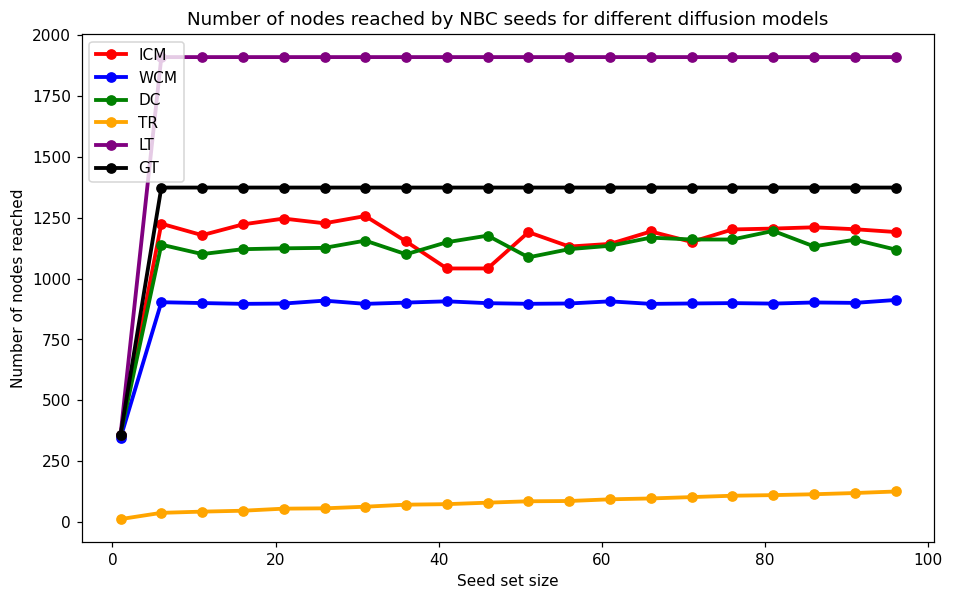

In [25]:
plt.figure(figsize=(10,6), dpi=110)
plt.plot(activate_nums_dict_nbc_icm.keys(), activate_nums_dict_nbc_icm.values(), color = "red", linewidth=2.5, linestyle="-", label="ICM", marker="o")
plt.plot(activate_nums_dict_nbc_wcm.keys(), activate_nums_dict_nbc_wcm.values(), color = "blue", linewidth=2.5, linestyle="-", label="WCM", marker="o")
plt.plot(activate_nums_dict_nbc_dc.keys(), activate_nums_dict_nbc_dc.values(), color = "green", linewidth=2.5, linestyle="-", label="DC", marker="o")
plt.plot(activate_nums_dict_nbc_tr.keys(), activate_nums_dict_nbc_tr.values(), color = "orange", linewidth=2.5, linestyle="-", label="TR", marker="o")
plt.plot(activate_nums_dict_nbc_lt.keys(), activate_nums_dict_nbc_lt.values(), color = "purple", linewidth=2.5, linestyle="-", label="LT", marker="o")
plt.plot(activate_nums_dict_nbc_gt.keys(), activate_nums_dict_nbc_gt.values(), color = "black", linewidth=2.5, linestyle="-", label="GT", marker="o")
plt.title("Number of nodes reached by NBC seeds for different diffusion models")
plt.ylabel("Number of nodes reached")
plt.xlabel("Seed set size")
plt.legend()

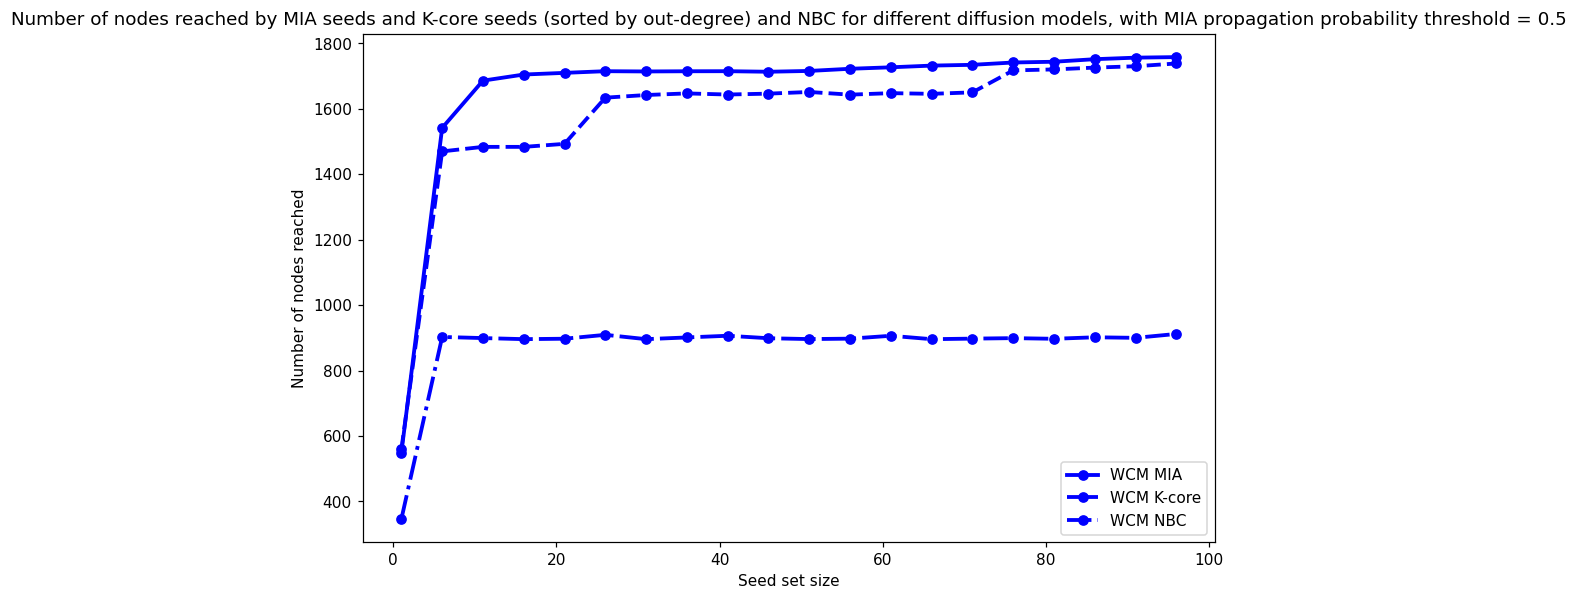

In [26]:
#combine the two plots
plt.figure(figsize=(10,6), dpi=110)
#plt.plot(activate_nums_dict_icm.keys(), activate_nums_dict_icm.values(), color = "red", linewidth=2.5, linestyle="-", label="ICM MIA", marker="o")
plt.plot(activate_nums_dict_wcm.keys(), activate_nums_dict_wcm.values(), color = "blue", linewidth=2.5, linestyle="-", label="WCM MIA", marker="o")
#plt.plot(activate_nums_dict_dc.keys(), activate_nums_dict_dc.values(), color = "green", linewidth=2.5, linestyle="-", label="DC MIA", marker="o")
#plt.plot(activate_nums_dict_tr.keys(), activate_nums_dict_tr.values(), color = "orange", linewidth=2.5, linestyle="-", label="TR MIA", marker="o")
#plt.plot(activate_nums_dict_lt.keys(), activate_nums_dict_lt.values(), color = "purple", linewidth=2.5, linestyle="-", label="LT MIA", marker="o")
#plt.plot(activate_nums_dict_gt.keys(), activate_nums_dict_gt.values(), color = "black", linewidth=2.5, linestyle="-", label="GT MIA", marker="o")

#plt.plot(activate_nums_dict_kcore_icm.keys(), activate_nums_dict_kcore_icm.values(), color = "red", linewidth=2.5, linestyle="--", label="ICM K-core", marker="o")
plt.plot(activate_nums_dict_kcore_wcm.keys(), activate_nums_dict_kcore_wcm.values(), color = "blue", linewidth=2.5, linestyle="--", label="WCM K-core", marker="o")
#plt.plot(activate_nums_dict_kcore_dc.keys(), activate_nums_dict_kcore_dc.values(), color = "green", linewidth=2.5, linestyle="--", label="DC K-core", marker="o")
#plt.plot(activate_nums_dict_kcore_tr.keys(), activate_nums_dict_kcore_tr.values(), color = "orange", linewidth=2.5, linestyle="--", label="TR K-core", marker="o")
#plt.plot(activate_nums_dict_kcore_lt.keys(), activate_nums_dict_kcore_lt.values(), color = "purple", linewidth=2.5, linestyle="--", label="LT K-core", marker="o")
#plt.plot(activate_nums_dict_kcore_gt.keys(), activate_nums_dict_kcore_gt.values(), color = "black", linewidth=2.5, linestyle="--", label="GT K-core", marker="o")

#plt.plot(activate_nums_dict_nbc_icm.keys(), activate_nums_dict_nbc_icm.values(), color = "red", linewidth=2.5, linestyle="-.", label="ICM NBC", marker="o")
plt.plot(activate_nums_dict_nbc_wcm.keys(), activate_nums_dict_nbc_wcm.values(), color = "blue", linewidth=2.5, linestyle="-.", label="WCM NBC", marker="o")
#plt.plot(activate_nums_dict_nbc_dc.keys(), activate_nums_dict_nbc_dc.values(), color = "green", linewidth=2.5, linestyle="-.", label="DC NBC", marker="o")
#plt.plot(activate_nums_dict_nbc_tr.keys(), activate_nums_dict_nbc_tr.values(), color = "orange", linewidth=2.5, linestyle="-.", label="TR NBC", marker="o")
#plt.plot(activate_nums_dict_nbc_lt.keys(), activate_nums_dict_nbc_lt.values(), color = "purple", linewidth=2.5, linestyle="-.", label="LT NBC", marker="o")
#plt.plot(activate_nums_dict_nbc_gt.keys(), activate_nums_dict_nbc_gt.values(), color = "black", linewidth=2.5, linestyle="-.", label="GT NBC", marker="o")

plt.title("Number of nodes reached by MIA seeds and K-core seeds (sorted by out-degree) and NBC for different diffusion models, with MIA propagation probability threshold = 0.5")
plt.ylabel("Number of nodes reached")
plt.xlabel("Seed set size")
plt.legend()

# Backup

## Trivalency probabilities + MIA 

In [8]:
trivalency_model_2020 = Trivalency_Model()
trivalency_model_2020.fit(pb2020)

In [8]:
# overwrite the weights in pb20_comms_subgraphs[12] as q/in-degree of the node for the outgoing edges of said node, where q=1
pb2020_trivalency = pb2020.copy()
for edge in pb2020_trivalency.edges():
    prob = trivalency_model_2020.probability[trivalency_model_2020.label2id[edge[0]], trivalency_model_2020.label2id[edge[1]]]
    
    if pb2020_trivalency.in_degree(edge[0]) == 0: # to avoid division by 0
        
        pb2020_trivalency[edge[0]][edge[1]]['weight'] = prob
        pb2020_trivalency[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob + 0.00000001)) # to avoid diverging to - infinity
    else:
        
        pb2020_trivalency[edge[0]][edge[1]]['weight'] = prob
        pb2020_trivalency[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob))

# turn the above code into a function where trivalency_model_2020 is the input, name the input "model"


In [11]:
np.unique([pb2020_trivalency[edge[0]][edge[1]]['weight'] for edge in pb2020_trivalency.edges()])

array([0.001, 0.01 , 0.1  ])

In [12]:
print(np.unique([pb2020_trivalency[edge[0]][edge[1]]['weight_negative_log'] for edge in pb2020_trivalency.edges()]))


[2.30258499 2.30258509 4.60516919 4.60517019 6.90774528 6.90775528]


In [13]:
mia_trivalency = MIA(pb2020_trivalency)

In [14]:
mia_trivalency.MIA_fast(pb2020_trivalency, 10, 0.5)

Starting MIA intialization


100%|██████████| 13217/13217 [00:30<00:00, 438.55it/s]


Initialization Completed


100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


['ColoradoPOYB',
 'ColoradoPOYB',
 'ColoradoPOYB',
 'ColoradoPOYB',
 'ColoradoPOYB',
 'ColoradoPOYB',
 'ColoradoPOYB',
 'ColoradoPOYB',
 'ColoradoPOYB',
 'ColoradoPOYB']

In [22]:
mia_trivalency.MIA_fast(pb2020_trivalency, 10, 0.01)

Starting MIA intialization


100%|██████████| 13217/13217 [08:48<00:00, 25.01it/s] 


Initialization Completed


100%|██████████| 10/10 [12:37<00:00, 75.78s/it]  


['Premises187',
 'SmashCM79',
 'enrique_tarrio',
 'Virgil_McMahon',
 'principe_giovan',
 'ProudBoysUS',
 'MoralDK',
 'UKProudBoys',
 'tpope88834',
 'proudboy_']

## ICM probabilities model + MIA

In [16]:
ICM_model_2020 = Independent_Cascade()
ICM_model_2020.fit(pb2020)

In [17]:
# overwrite the weights in pb20_comms_subgraphs[12] as q/in-degree of the node for the outgoing edges of said node, where q=1
pb2020_ICM = pb2020.copy()
for edge in pb2020_ICM.edges():
    prob = ICM_model_2020.probability[ICM_model_2020.label2id[edge[0]], ICM_model_2020.label2id[edge[1]]]
    
    if pb2020_ICM.in_degree(edge[0]) == 0: # to avoid division by 0
        
        pb2020_ICM[edge[0]][edge[1]]['weight'] = prob
        pb2020_ICM[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob + 0.00000001)) # to avoid diverging to - infinity
    else:
        
        pb2020_ICM[edge[0]][edge[1]]['weight'] = prob
        pb2020_ICM[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob))


In [18]:
np.unique([pb2020_ICM[edge[0]][edge[1]]['weight'] for edge in pb2020_ICM.edges()])

array([0.16666667, 0.2       , 0.25      , 0.33333333, 0.5       ,
       1.        ])

In [19]:
np.unique([pb2020_ICM[edge[0]][edge[1]]['weight_negative_log'] for edge in pb2020_ICM.edges()])

array([0.00000000e+00, 9.99999989e-09, 6.93147161e-01, 1.09861226e+00,
       1.09861229e+00, 1.38629432e+00, 1.38629436e+00, 1.60943786e+00,
       1.60943791e+00, 1.79175941e+00, 1.79175947e+00])

In [20]:
mia_ICM = MIA(pb2020_ICM)

In [21]:
mia_ICM.MIA_fast(pb2020_ICM, 10, 0.5)

Starting MIA intialization


100%|██████████| 13217/13217 [00:30<00:00, 427.08it/s]


Initialization Completed


100%|██████████| 10/10 [02:09<00:00, 12.96s/it]


['Premises187',
 'SmashCM79',
 'enrique_tarrio',
 'ProudGirlUK',
 'ProudBoysUS',
 'principe_giovan',
 'proudboy_',
 'MoralDK',
 'TheWesternChauv',
 'proudboy2012']